In [90]:
import json
import numpy as np

data = json.load(open('data/jsb-chorales-16th.json'))

# Data:
''' 
Train (229) Test (77) Valid (76) split
Each has a list of sequences
Each sequence is a list of time steps
Each time step is a list of notes (MIDI numbers: [21 -- 108])

So vocab size is 128 + extra tokens used
'''

len(data['train']) 

229

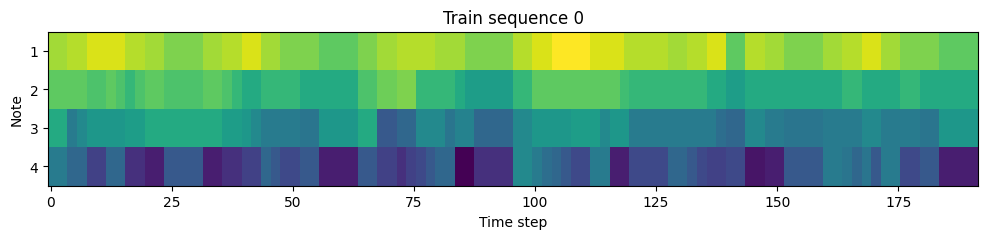

In [91]:
import matplotlib.pyplot as plt

i = 0
train = data['train'][i]

plt.figure(figsize=(12, 2))
plt.title(f"Train sequence {i}")
plt.imshow(np.array(train).T, aspect='auto')
plt.yticks(np.arange(4), np.arange(4)+1)
plt.xlabel('Time step')
plt.ylabel('Note')
plt.show()

In [96]:
# The music data is already tokenized, since it are integers (MIDI numbers)
import torch
import time

# We can visualize each timestep with four notes as a 'sentence', so adding an <eos> token at the end.
n_sequences = len(data['train'])
n_notes = 4 # one exception
max_timesteps = max(len(sequence) for sequence in data['train'])

# eos_token_id is not defined, since we have no tokenizer. -1 means silence, so let use -2 as eos.
eos_token_id = -2
mask_token_id = -3
pad_token_id = 0

vocab_size = 128 + 3 # 128 notes + 3 extra tokens

# input_ids should be [n_sequences, n_timesteps * (n_notes + 1)]
# we append the eos tokens ad hoc
labels = np.ones([n_sequences, max_timesteps * n_notes], dtype=int) * pad_token_id
print(labels.shape)

start_time = time.time()
for i_seq in range(n_sequences):
    n_timesteps = len(data['train'][i_seq])
    for i_time in range(n_timesteps):
        n_notes = len(data['train'][i_seq][i_time])
        if n_notes != 4:
            break
        for i_note in range(n_notes):
            if i_note == 3:
                # end of sentence reached, i.e.: after four notes in a timestep.
                np.append(labels, eos_token_id)
            else:
                labels[i_seq, i_time * n_notes + i_note] = int(data['train'][i_seq][i_time][i_note])
end_time = time.time()
print(f"Time to process: {end_time - start_time:.2f} seconds")

mask = labels != 0
input_ids = np.copy(labels)

# Now, mask 15% of the labels randomly to use as input
random_mask = np.random.rand(*labels.shape) < 0.15
input_ids[random_mask] = mask_token_id

encodings = {'input_ids': input_ids, 'attention_mask': mask, 'labels': labels}

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        # store encodings internally
        self.encodings = encodings

    def __len__(self):
        # return the number of samples
        return self.encodings['input_ids'].shape[0]

    def __getitem__(self, i):
        # return dictionary of input_ids, attention_mask, and labels for index i
        return {key: tensor[i] for key, tensor in self.encodings.items()}

print("first 100 input_ids (with noise) of the first sequence:")
input_ids[0][0:100]

(229, 2064)
Time to process: 11.16 seconds
first 100 input_ids (with noise) of the first sequence:


array([74, 70, 65,  0, 74, 70, -3,  0, 74, 70, 65, -3, 74, 70, -3,  0, 75,
       70, 58,  0, 75, 70, 58,  0, 75, 70, 60,  0, 75, 70, 60,  0, 77, 69,
       -3,  0, 77, 69, 62,  0, 77, -3, 62,  0, 77, 69, 62,  0, 77, 70, 62,
        0, 77, -3, 62, -3, 77, 69, 62,  0, 77, 69, 62,  0, 75, 67, 63,  0,
       75, 67, 63,  0, 75, -3, -3,  0, 75, 69, -3,  0, 74, 70, 65,  0, 74,
       -3, 65,  0, -3, 70, -3,  0, 74, 70, 65, -3, 72, 69, 65, -3])

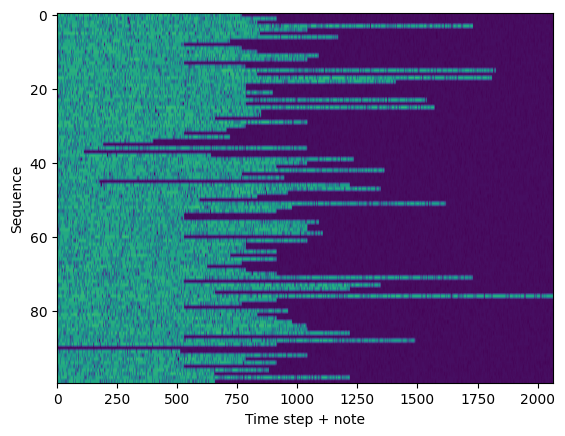

In [93]:
plt.imshow(input_ids[0:100], aspect='auto', cmap='viridis')
plt.xlabel('Time step + note')
plt.ylabel('Sequence')
plt.show()

In [94]:
dataset = Dataset(encodings)
loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)


In [100]:
from transformers import RobertaConfig, RobertaForMaskedLM

config = RobertaConfig(
    vocab_size=vocab_size,
    max_position_embeddings=2064, # how far to do cross-attention (full length of sequence)
    hidden_size=768,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1
)

model = RobertaForMaskedLM(config)

device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
model.to(device)

from transformers import AdamW

# activate training mode
model.train()
# initialize optimizer
optim = AdamW(model.parameters(), lr=1e-4)


/Users/freek/Documents/repos/music-transformer/.venv/lib/python3.12/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [101]:
from tqdm import tqdm 

epochs = 2

for epoch in range(epochs):
    loop = tqdm(loader, leave=True)
    for batch in loop:
        # initialize calculated gradients (from prev step)
        optim.zero_grad()
        # pull all tensor batches required for training
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        # process
        outputs = model(input_ids, attention_mask=attention_mask,
                        labels=labels)
        # extract loss
        loss = outputs.loss
        # calculate loss for every parameter that needs grad update
        loss.backward()
        # update parameters
        optim.step()
        # print relevant info to progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

  0%|          | 0/15 [00:15<?, ?it/s]


RuntimeError: MPS backend out of memory (MPS allocated: 32.84 GB, other allocations: 3.25 GB, max allowed: 36.27 GB). Tried to allocate 3.05 GB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).